# Predicting House prices

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


### Make all the necessary imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Read data

In [3]:
df = pd.read_csv('train.csv')

## Feature Engineering

- Crucial part of ML application development
- Steps:
    - Investigate your features for data-types
    - Be wary of NULLs, make appropriate feature imputations (there is an entire area of ML research dedicated to this)
    - Try to bucket your features into continous, categorical, ordinal and accordingly apply transformations
    - Convert time-based features into cyclical form (sin/cosine transforms are popular)

### Inspect data
- Look at data-types
- Check for NULLs
- Think about how to represent data to the model, remember that models only understand numbers

In [4]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [5]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Feature imputation
- What is this?
  Provide meaningful values to replace missing values
  
### Common Ways
- Replacing all NULLs with 0 (only use for numeric columns)
- For categorical etc, use backfill/ padding/ or a separate value to indicate absence if you want to capture that value

In [6]:
data_types = df.dtypes.to_dict()
for col in df:
    if data_types[col] == 'int64':
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype('float64')
    else:
        df[col] = df[col].fillna(value='No')
        df[col] = df[col].astype('str')

In [7]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,0.0,No,No,No,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,0.0,No,No,No,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,No,IR1,Lvl,AllPub,...,0.0,No,No,No,0.0,9.0,2008.0,WD,Normal,223500.0


## Convert data into a tooling of your choice
- Common choices are sklearn, spark MLlib, H2O

In [8]:
spark_df = spark.createDataFrame(df)

### Gather features for Exploratory Data Analysis (EDA)

In [9]:
features = [col for col in spark_df.columns if col not in ['Id','SalePrice','is_train']]
label = 'SalePrice'

## Lack of domain expertise may lead to engineering features differently
For ex: I dont know what different materials for roof are better for which type of neighbourhood, if I did, I would have introduced some of my domain knowledge, but I am not an expert in real-estate here, so I end up shoving a lot of things into the model as categorical

In [10]:
# special cases
# the below will now become a continous feature
spark_df = spark_df.withColumn('years_since_remodel', spark_df['YearRemodAdd']-spark_df['YearBuilt'])

In [11]:
cat_vars = [
    'MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','LotConfig','LandSlope',
    'Neighborhood', 'Condition1', 'Condition2','BldgType','HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType','Foundation','Heating','Electrical','GarageType'] # order does not matter
ordinal_vars = ['Utilities','ExterQual', 'ExterCond','BsmtQual','BsmtExposure', 'BsmtFinType1','BsmtFinType2',
               'HeatingQC','CentralAir','Functional','KitchenQual','FireplaceQu','GarageFinish',
                'GarageCond', 'PavedDrive','PoolQC', 'Fence', 'MiscFeature','SaleType', 'SaleCondition','BsmtCond'] # where order matters
ordinal_vars_already_converted = [ 'OverallQual', 'OverallCond'] # no need to convert these
cyclical_vars = ['YearBuilt','MoSold', 'YrSold'] # time-based features

In [12]:
spark_df.select(cyclical_vars).show(3)

+---------+------+------+
|YearBuilt|MoSold|YrSold|
+---------+------+------+
|   2003.0|   2.0|2008.0|
|   1976.0|   5.0|2007.0|
|   2001.0|   9.0|2008.0|
+---------+------+------+
only showing top 3 rows



### Transform ordinal features
Assign numbers --> each value in ordinal features column

In [13]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

### Ordinal transforms

In [14]:
indexers = [
    StringIndexer(inputCol=ordinal_var, outputCol=ordinal_var+'_indexed')
    for ordinal_var in ordinal_vars
]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(spark_df).transform(spark_df)

transformed_ordinal_vars = [ordinal_var+'_indexed' for ordinal_var in ordinal_vars]

### Categorical transforms

In [15]:
cat_indexers = [
    StringIndexer(inputCol=cat_var, outputCol=cat_var+'_indexed')
    for cat_var in cat_vars
]
cat_one_hot_encoders = [
    OneHotEncoder(inputCol=cat_var+'_indexed', outputCol=cat_var+'_encoded')
    for cat_var in cat_vars
]
cat_pipeline = Pipeline(stages=cat_indexers+cat_one_hot_encoders)
df_encoded = cat_pipeline.fit(df_indexed).transform(df_indexed)

transformed_cat_vars = [cat_var+'_encoded' for cat_var in cat_vars]

### Cyclical transforms

In [16]:
from pyspark.sql.functions import sin, cos

transformed_cyclical_vars = []
for cyclical_var in cyclical_vars:
    df_encoded = df_encoded.withColumn(cyclical_var+'_sin', sin(df_encoded[cyclical_var]))
    df_encoded = df_encoded.withColumn(cyclical_var+'_cos', cos(df_encoded[cyclical_var]))
    transformed_cyclical_vars += [cyclical_var+'_sin', cyclical_var+'_cos']

### Continous Features

In [17]:
from pyspark.sql.types import FloatType

continous_vars = list(set(features).difference(set(cat_vars+ordinal_vars+cyclical_vars)))
for column in continous_vars:
    df_encoded = df_encoded.withColumn(column, df_encoded[column].cast(FloatType()))

### Verify that your code is working as expected

In [18]:
assert set(transformed_ordinal_vars).intersection(set(df_encoded.columns)) == set(transformed_ordinal_vars)

In [19]:
assert set(transformed_cat_vars).intersection(set(df_encoded.columns)) == set(transformed_cat_vars)

### Gather all features

In [20]:
transformed_features = transformed_ordinal_vars + transformed_cyclical_vars + transformed_cat_vars + continous_vars

df_encoded = df_encoded.select(transformed_features+[label]+['Id'])

In [21]:
df_encoded = df_encoded.fillna(0)
df_encoded = df_encoded.select([col for col in df_encoded.columns if col!='features'])

In [22]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=transformed_features, outputCol='features')
df_encoded = assembler.transform(df_encoded)

In [23]:
df_encoded = df_encoded.withColumn(label, df_encoded[label].cast(FloatType()))

### Train
- Split between test & training sets

In [24]:
train_df, test_df = df_encoded.randomSplit([0.9,0.1])

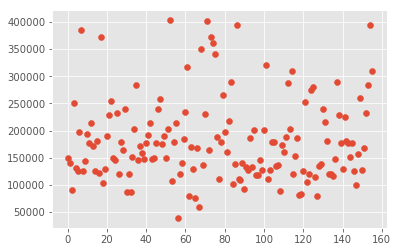

In [25]:
viz_df = test_df.toPandas()
plt.scatter(x=list(range(len(viz_df))), y=list(viz_df['SalePrice']))

### Define evaluation metrics
- Define couple of evaluation metrics

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=label, metricName='rmse')
mae_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=label, metricName='mae')
rmse_evaluator_log = RegressionEvaluator(predictionCol='log_prediction', labelCol='log_label', metricName='rmse')

### Linear Regression

RMSE: 26542.079216708386
MAE: 20432.68629045803
RMSE log: 0.15343325303248773


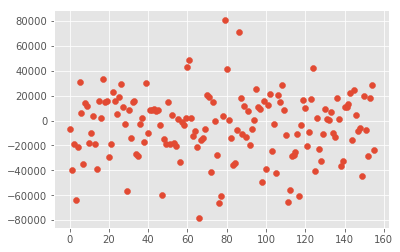

In [27]:
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import log

lr = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

lr_predictions = lr_model.transform(test_df)
lr_predictions = lr_predictions.withColumn('log_label', log(lr_predictions['SalePrice']))
lr_predictions = lr_predictions.withColumn('log_prediction', log(lr_predictions['prediction']))


lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)
lr_rmse_log = rmse_evaluator_log.evaluate(lr_predictions)


print ('RMSE: {}'.format(lr_rmse))
print ('MAE: {}'.format(lr_mae))
print ('RMSE log: {}'.format(lr_rmse_log))

lr_predictions_pd = lr_predictions.toPandas()
lr_predictions_pd['residuals'] = lr_predictions_pd['SalePrice']-lr_predictions_pd['prediction']
plt.scatter(x=list(range(len(lr_predictions_pd))), y=list(lr_predictions_pd['residuals']))

RMSE: 27592.201532144558
MAE: 21178.345623297708
RMSE log: 0.15964654066027528


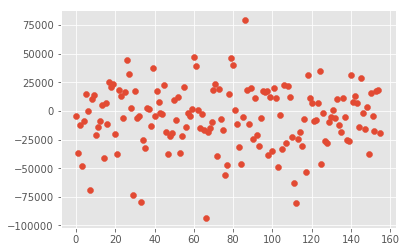

In [28]:
from pyspark.ml.regression import LinearRegression

lr_50 = LinearRegression(featuresCol='features', labelCol='SalePrice', maxIter=50, regParam=0.3, elasticNetParam=0.8)
lr_model_50 = lr_50.fit(train_df)

lr_predictions = lr_model_50.transform(test_df)
lr_predictions = lr_predictions.withColumn('log_label', log(lr_predictions['SalePrice']))
lr_predictions = lr_predictions.withColumn('log_prediction', log(lr_predictions['prediction']))


lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_mae = mae_evaluator.evaluate(lr_predictions)
lr_rmse_log = rmse_evaluator_log.evaluate(lr_predictions)


print ('RMSE: {}'.format(lr_rmse))
print ('MAE: {}'.format(lr_mae))
print ('RMSE log: {}'.format(lr_rmse_log))


lr_predictions_pd = lr_predictions.toPandas()
lr_predictions_pd['residuals'] = lr_predictions_pd['SalePrice']-lr_predictions_pd['prediction']
plt.scatter(x=list(range(len(lr_predictions_pd))), y=list(lr_predictions_pd['residuals']))

### XGBoost

In [29]:
import spark_tools.ml.xgboost as pyspark_xgboost
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

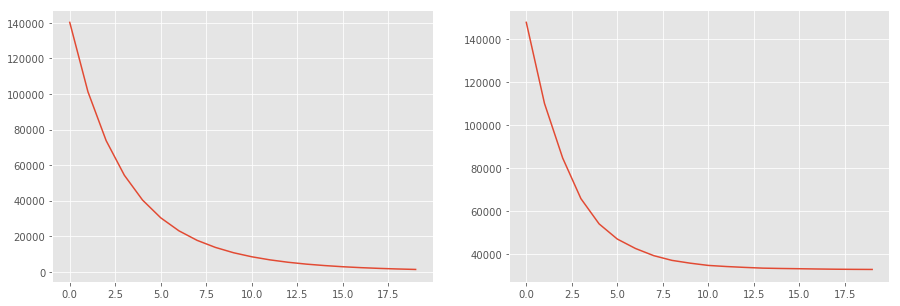

In [30]:
XGBOOST_HYPERPARAMETERS = {
    'featuresCol': 'features',
    'labelCol': label, 
    'predictionCol': "prediction",
    'objective': 'reg:linear',
    'trainTestRatio':0.7,
    'max_depth': 32,
    'num_round':20,
    'early_stopping': 2,
}

xgboost_estimator = pyspark_xgboost.XGBoost(XGBOOST_HYPERPARAMETERS)
xgboost_model = xgboost_estimator.fit(train_df)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(xgboost_model.training_summary['train'])
ax[1].plot(xgboost_model.training_summary['test'])

In [31]:
xgboost_predictions = xgboost_model.transform(test_df)
xgboost_predictions = xgboost_predictions.withColumn('log_label', log(xgboost_predictions['SalePrice']))
xgboost_predictions = xgboost_predictions.withColumn('log_prediction', log(xgboost_predictions['prediction']))


xgboost_rmse = rmse_evaluator.evaluate(xgboost_predictions)
xgboost_mae = mae_evaluator.evaluate(xgboost_predictions)
xgboost_log = rmse_evaluator_log.evaluate(xgboost_predictions)

print ('RMSE: {}'.format(xgboost_rmse))
print ('MAE: {}'.format(xgboost_mae))
print ('RMSE log: {}'.format(xgboost_log))

RMSE: 27913.209988948052
MAE: 20040.349584334937
RMSE log: 0.14672379055516907


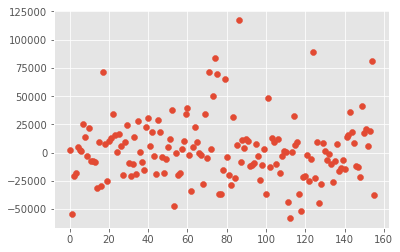

In [32]:
xgb_predicts = xgboost_model.transform(test_df).toPandas()
xgb_predicts['residuals'] = xgb_predicts['SalePrice']-xgb_predicts['prediction']
plt.scatter(x=list(range(len(xgb_predicts))), y=list(xgb_predicts['residuals']))

### Can we do better?

RMSE: 23598.777459072102
MAE: 16898.851036658652
RMSE log: 0.13090016347924752


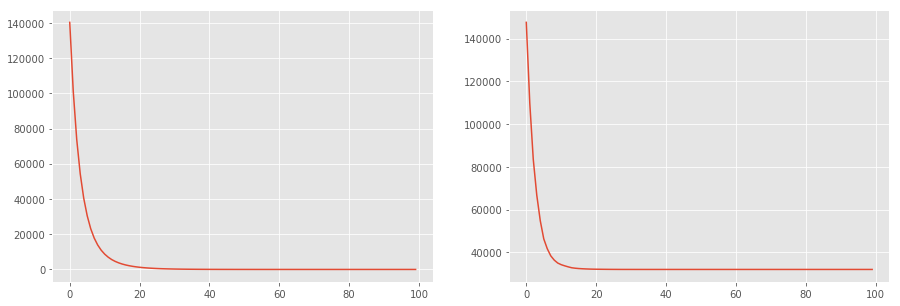

In [33]:
XGBOOST_HYPERPARAMETERS = {
    'featuresCol': 'features',
    'labelCol': label, 
    'predictionCol': "prediction",
    'objective': 'reg:linear',
    'trainTestRatio':0.7,
    'max_depth': 32,
    'num_round':100,
}

xgboost_estimator = pyspark_xgboost.XGBoost(XGBOOST_HYPERPARAMETERS)
xgboost_model_1 = xgboost_estimator.fit(train_df)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(xgboost_model_1.training_summary['train'])
ax[1].plot(xgboost_model_1.training_summary['test'])

xgboost_predictions = xgboost_model_1.transform(test_df)
xgboost_predictions = xgboost_predictions.withColumn('log_label', log(xgboost_predictions['SalePrice']))
xgboost_predictions = xgboost_predictions.withColumn('log_prediction', log(xgboost_predictions['prediction']))


xgboost_rmse = rmse_evaluator.evaluate(xgboost_predictions)
xgboost_mae = mae_evaluator.evaluate(xgboost_predictions)
xgboost_log = rmse_evaluator_log.evaluate(xgboost_predictions)

print ('RMSE: {}'.format(xgboost_rmse))
print ('MAE: {}'.format(xgboost_mae))
print ('RMSE log: {}'.format(xgboost_log))

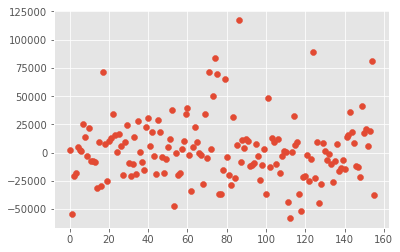

In [34]:
xgb_predicts = xgboost_model.transform(test_df).toPandas()
xgb_predicts['residuals'] = xgb_predicts['SalePrice']-xgb_predicts['prediction']
plt.scatter(x=list(range(len(xgb_predicts))), y=list(xgb_predicts['residuals']))

### Hyper-parameter tuning

RMSE: 24907.732530992755
MAE: 17602.212665264422
RMSE log: 0.13762675975159802


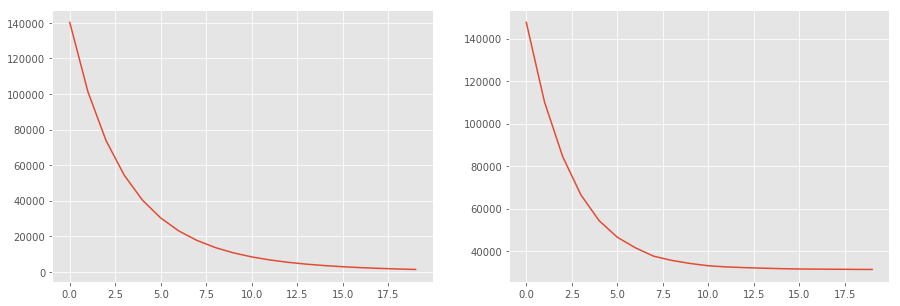

In [35]:
XGBOOST_HYPERPARAMETERS = {
    'featuresCol': 'features',
    'labelCol': label, 
    'predictionCol': "prediction",
    'objective': 'reg:linear',
    'trainTestRatio':0.7,
    'max_depth': 64,
    'num_round':20,
    'early_stopping': 2,
}

xgboost_estimator = pyspark_xgboost.XGBoost(XGBOOST_HYPERPARAMETERS)
xgboost_model_2 = xgboost_estimator.fit(train_df)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(xgboost_model_2.training_summary['train'])
ax[1].plot(xgboost_model_2.training_summary['test'])

xgboost_predictions = xgboost_model_2.transform(test_df)
xgboost_predictions = xgboost_predictions.withColumn('log_label', log(xgboost_predictions['SalePrice']))
xgboost_predictions = xgboost_predictions.withColumn('log_prediction', log(xgboost_predictions['prediction']))


xgboost_rmse = rmse_evaluator.evaluate(xgboost_predictions)
xgboost_mae = mae_evaluator.evaluate(xgboost_predictions)
xgboost_log = rmse_evaluator_log.evaluate(xgboost_predictions)

print ('RMSE: {}'.format(xgboost_rmse))
print ('MAE: {}'.format(xgboost_mae))
print ('RMSE log: {}'.format(xgboost_log))

RMSE: 24379.579990071205
MAE: 16724.48314803686
RMSE log: 0.13258960572930245


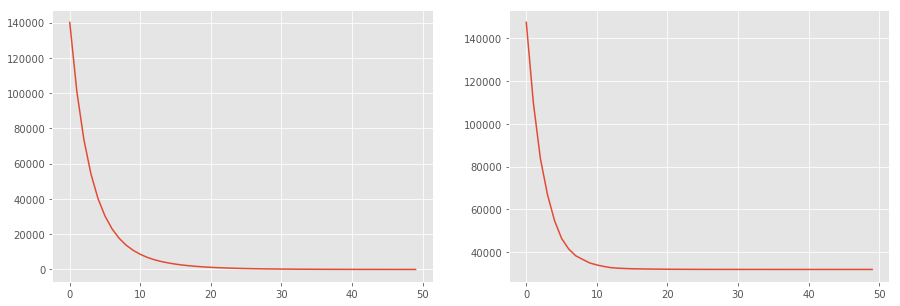

In [36]:
XGBOOST_HYPERPARAMETERS = {
    'featuresCol': 'features',
    'labelCol': label, 
    'predictionCol': "prediction",
    'objective': 'reg:linear',
    'trainTestRatio':0.7,
    'max_depth': 64,
    'num_round':50,
    'early_stopping': 2,
}

xgboost_estimator = pyspark_xgboost.XGBoost(XGBOOST_HYPERPARAMETERS)
xgboost_model_3 = xgboost_estimator.fit(train_df)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(xgboost_model_3.training_summary['train'])
ax[1].plot(xgboost_model_3.training_summary['test'])

xgboost_predictions = xgboost_model_3.transform(test_df)
xgboost_predictions = xgboost_predictions.withColumn('log_label', log(xgboost_predictions['SalePrice']))
xgboost_predictions = xgboost_predictions.withColumn('log_prediction', log(xgboost_predictions['prediction']))


xgboost_rmse = rmse_evaluator.evaluate(xgboost_predictions)
xgboost_mae = mae_evaluator.evaluate(xgboost_predictions)
xgboost_log = rmse_evaluator_log.evaluate(xgboost_predictions)

print ('RMSE: {}'.format(xgboost_rmse))
print ('MAE: {}'.format(xgboost_mae))
print ('RMSE log: {}'.format(xgboost_log))

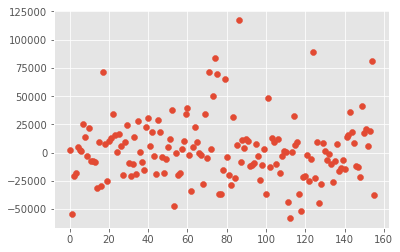

In [37]:
xgb_predicts = xgboost_model.transform(test_df).toPandas()
xgb_predicts['residuals'] = xgb_predicts['SalePrice']-xgb_predicts['prediction']
plt.scatter(x=list(range(len(xgb_predicts))), y=list(xgb_predicts['residuals']))

### What are the top_10 features for our best model?
- The below is what our best model says

In [43]:
def extract_feature_map(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp['f'+str(x)] if 'f'+str(x) in featureImp else 0)
    return(varlist.sort_values('score', ascending = False))

extract_feature_map(xgboost_model_2.get_score(), train_df, "features").head(10)

,idx,name,score
21,21,YearBuilt_sin,134
22,22,YearBuilt_cos,126
44,193,GrLivArea,123
4,4,BsmtExposure_indexed,117
56,205,GarageArea,115
23,23,MoSold_sin,115
32,181,BsmtUnfSF,108
5,5,BsmtFinType1_indexed,105
34,183,BsmtFinSF1,100
40,189,MasVnrArea,99


In [44]:
extract_feature_map(xgboost_model_3.get_score(), train_df, "features").head(10)

,idx,name,score
5,5,BsmtFinType1_indexed,690
4,4,BsmtExposure_indexed,625
21,21,YearBuilt_sin,579
22,22,YearBuilt_cos,504
23,23,MoSold_sin,489
1,1,ExterQual_indexed,483
32,181,BsmtUnfSF,476
34,183,BsmtFinSF1,403
40,189,MasVnrArea,383
53,202,LotFrontage,378
